In [2]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from io_utils import *
%load_ext memory_profiler

In [3]:
dataset_val = 0

In [4]:
if dataset_val == 0:
    dataset =  "PLAsTiCC"
    data_ob = load_PLAsTiCC_data()
    object_ids = data_ob.get_all_object_ids()
    kilonova_ids=data_ob.get_ids_of_event_type(64)
    color_band_dict = {0:'C4',1:'C2', 2:'C3', 3:'C1', 4:'k', 5:'C5'}

In [5]:
def getredshift(data_ob , object_id):
    df_meta_data = data_ob.df_metadata
    index = np.where(df_meta_data['object_id']==object_id)
    red_shift_specz = df_meta_data['hostgal_specz'][index]
    red_shift_photoz = df_meta_data['hostgal_photoz'][index]
    return red_shift_specz, red_shift_photoz

In [6]:
all_object_ids = data_ob.get_all_object_ids()
kilonova_ids=data_ob.get_ids_of_event_type(64)
print(all_object_ids)

object_id
---------
      615
      713
      730
      745
     1124
     1227
     1598
     1632
     1920
     1926
      ...
130678775
130684460
130695262
130698059
130716752
130727624
130739978
130755807
130762946
130772921
130779836
Length = 7848 rows


In [7]:
from LightCurve import LightCurve

In [8]:
flux_and_error_diff = np.abs(data_ob.df_data[data_ob.flux_col_name]) - np.abs(data_ob.df_data[data_ob.flux_err_col_name])
flux_err_ratio = np.abs(data_ob.df_data[data_ob.flux_col_name])>2*data_ob.df_data[data_ob.flux_err_col_name]
index = (np.abs(flux_and_error_diff)>10)&(flux_err_ratio)

In [9]:
def calc_transient_pausibility(object_df):
    
    if len(object_df)==0:
        pausibility = 0
        
    else:
    
        max_flux_pos = np.argmax(object_df[data_ob.flux_col_name])

        #length =len(object_df['mjd'])
        max_flux_date = object_df[data_ob.time_col_name][max_flux_pos]
        max_flux_val = object_df[data_ob.flux_col_name][max_flux_pos]
        #print(object_df['flux_err'])


        time_from_max = np.abs(object_df[data_ob.time_col_name] - max_flux_date)
        time_from_max[np.where(time_from_max<7)] = 0
        #filtered_flux = object_df['flux']
        length = np.sum(np.where(time_from_max>=0))

        #normalization = np.sum(index_greater_than_half)
        pausibility = np.sum(np.abs(object_df[data_ob.flux_col_name])*np.abs(time_from_max))/max_flux_val
        #print(pausibility)
        
    return pausibility

In [18]:
def filter_kilonovae(data_ob):
    
    object_ids = data_ob.get_all_object_ids()
    filter_result = np.zeros(len(object_ids), dtype=bool)
    for i,object_id in enumerate(object_ids):
        mask = data_ob.df_data[data_ob.object_id_col_name] == object_id
        object_df = data_ob.df_data[mask]
        flux_and_error_diff = np.abs(object_df[data_ob.flux_col_name]) - np.abs(object_df[data_ob.flux_err_col_name])
        flux_err_ratio = np.abs(object_df[data_ob.flux_col_name])>2*object_df[data_ob.flux_err_col_name]
        index = (np.abs(flux_and_error_diff)>10)&(flux_err_ratio)
        object_df= object_df[index]
        pausibility = calc_transient_pausibility(object_df)
        max_per_band = []
        if pausibility>1500:
            continue
        for band in range(6):
            band_mask = data_ob.df_data[data_ob.band_col_name]==band
            band_df = data_ob.df_data[band_mask*mask]
            if len(band_df)>0:
                max_per_band.append(np.amax(band_df[data_ob.flux_col_name]))
            else:
                max_per_band.append(0)
        
        if (max_per_band[1]<11000)&(max_per_band[2]<10000)&(max_per_band[3]<8000)&(max_per_band[4]<8000)&(max_per_band[5]<8000):
            filter_result[i] = True 
            
    data_ob.df_metadata['filter_result'] = filter_result

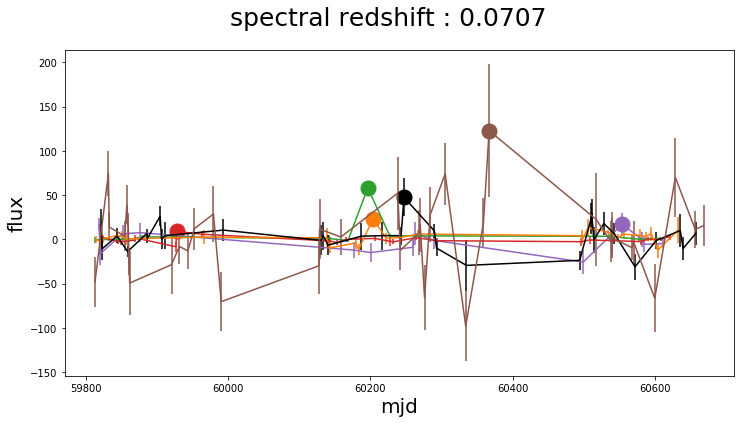

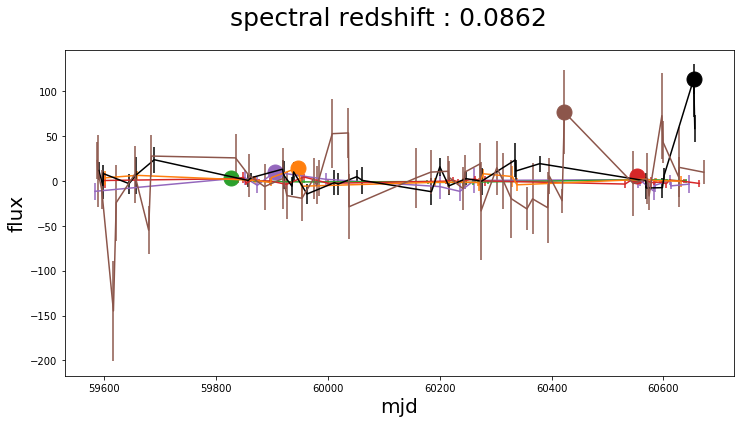

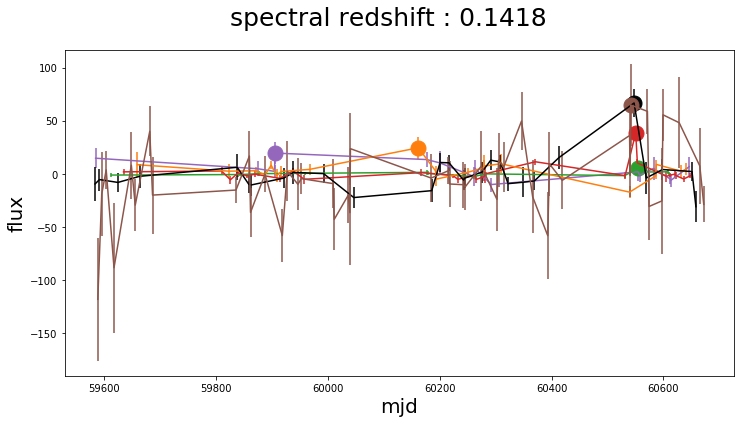

In [23]:
accepted_kilonovae =0
accepted_events = 0

for i, object_id in enumerate(all_object_ids):
    #print(data_ob.df_data[data_ob.object_id_col_name])
    mask = data_ob.df_data[data_ob.object_id_col_name] == object_id
    object_df = data_ob.df_data[mask&index]
    pausibility = calc_transient_pausibility(object_df)
        #print(pausibility)
        #lc = LightCurve(object_df,"mjd","flux","flux_err","passband")
        
    max_per_band = []
    for band in range(6):
        band_mask = data_ob.df_data[data_ob.band_col_name]==band
        band_df = data_ob.df_data[band_mask*mask]
        max_per_band.append(np.amax(band_df[data_ob.flux_col_name]))

    if (pausibility<1500)&(max_per_band[0]<1500)&(max_per_band[1]<11000)&(max_per_band[2]<10000)&(max_per_band[3]<8000)&(max_per_band[4]<8000)&(max_per_band[5]<8000):
        #if (pausibility<1500):
        if np.sum(kilonova_ids==object_id)==1:
            accepted_kilonovae+=1
        accepted_events = accepted_events+1
        
    else:
        if np.sum(kilonova_ids==object_id)==1:
            lc = LightCurve(data_ob.get_data_of_event(object_id), time_col_name=data_ob.time_col_name, brightness_col_name=data_ob.flux_col_name, brightness_err_col_name=data_ob.flux_err_col_name,band_col_name=data_ob.band_col_name, band_map=data_ob.band_map)
            red_shift,_ = getredshift(data_ob, object_id)
            fig=lc.plot_light_curve(color_band_dict)
            fig.suptitle("spectral redshift : "+ str(red_shift[0]), fontsize=25)
            #plt.show()
            #fig.savefig("./kilonova_curves/Wrongly_rejected/"+str(object_id)+"_failed")
            #plt.close('all')

In [24]:
print("Fraction of kilonavae events accepted : "+ str(accepted_kilonovae)+"/"+"102")
print("Fraction of all events accepted : "+ str(accepted_events)+"/"+str(len(all_object_ids)))

Fraction of kilonavae events accepted : 99/102
Fraction of all events accepted : 5959/7848


In [25]:
print("Percentage of kilonavae events accepted : "+ str(100-accepted_kilonovae/102*100))
print("Percentage of all events Rejected : "+ str(100 - accepted_events/len(all_object_ids)*100))

Percentage of kilonavae events accepted : 2.941176470588232
Percentage of all events Rejected : 24.069826707441393


In [19]:
filter_result = filter_kilonovae(data_ob)

In [20]:
len(filter_result)

7848

In [26]:
filter_result

array([False, False,  True, ..., False,  True, False])

In [22]:
data_ob.df_metadata['filter_result'] = filter_result

# HISTOGRAM OF METRIC

In [ ]:
kilonovae_pausibility = []
nonkilo_pausibility = []

for i, object_id in enumerate(all_object_ids):
    
    mask = data_ob.df_data[data_ob.object_id_col_name] == object_id
    #print(mask)
    object_df = data_ob.df_data[mask*index]
    
    print(len(object_df))
    if len(object_df)==0:
        pausibility = 0
        
    else:
    
        max_flux_pos = np.argmax(object_df[data_ob.flux_col_name])

        #length =len(object_df['mjd'])
        max_flux_date = object_df[data_ob.time_col_name][max_flux_pos]
        max_flux_val = object_df[data_ob.flux_col_name][max_flux_pos]
        #print(object_df['flux_err'])


        time_from_max = np.abs(object_df[data_ob.time_col_name] - max_flux_date)
        time_from_max[np.where(time_from_max<7)] = 0
        #print(time_from_max)
        #filtered_flux = object_df['flux']
        length = np.sum(np.where(time_from_max>=0))

        #normalization = np.sum(index_greater_than_half)
        pausibility = np.sum(np.abs(object_df[data_ob.flux_col_name])*np.abs(time_from_max))/max_flux_val
        
    if np.sum(kilonova_ids==object_id)==1:
        kilonovae_pausibility.append(pausibility)

    else:
        nonkilo_pausibility.append(pausibility)

In [ ]:
print(kilonovae_pausibility)

In [ ]:
print(nonkilo_pausibility)

In [ ]:
plt.hist(np.log(np.asarray(kilonovae_pausibility)+1),bins=50,label=['kilonovae','Non-kilnovae'])

In [ ]:
plt.hist(np.log(np.asarray(nonkilo_pausibility)+1),bins=100,label=['kilonovae','Non-kilnovae'])

In [ ]:
y1 = np.log(np.asarray(kilonovae_pausibility)+1)
y2 = np.log(np.asarray(nonkilo_pausibility)+1)

In [ ]:
colors = ['b','g']

#sets up the axis and gets histogram data
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.hist([y1, y2], color=colors)
n, bins, patches = ax1.hist([y1,y2],bins=50)
ax1.cla() 

#plots the histogram data
width = (bins[1] - bins[0])
bins_shifted = bins
ax1.bar(bins[:-1], n[0], width, color=colors[0],alpha = .6,label="kilonova")
ax2.bar(bins[:-1], n[1], width, color=colors[1],alpha = .6, label="non-kilonova")

#finishes the plot
ax1.set_ylabel("kilonovae Count", color=colors[0],fontsize=15)
ax2.set_ylabel("non-kilonovae Count", color=colors[1],fontsize=15)
ax1.tick_params('y', colors=colors[0])
ax2.tick_params('y', colors=colors[1])
ax1.set_xlabel("$\ln{\;(\;TP+1\;)}$",fontsize=15)
fig.savefig("distribution_of_metric")
plt.tight_layout()
plt.show()

In [ ]:
y3= []
y4 = []
for object_id in object_ids:
    mask = data_ob.df_data[data_ob.object_id_col_name] == object_id
    object_df = data_ob.df_data[mask&index]
    if len(object_df)>0:
        max_time = np.amax(object_df[data_ob.time_col_name])
        min_time = max_time-365
        time_index = object_df[data_ob.time_col_name]>=min_time
        object_df = object_df[time_index]
        print("\n---------------------------------------")
        print(max_time- np.amin(object_df[data_ob.time_col_name]))
        #print(object_df[data_ob.time_col_name])
    is_tran = data_ob.is_transient(object_id)
    #print(is_tran)
    if is_tran == None: 
        print("error")
    elif is_tran==1:
        y3.append(calc_transient_pausibility(object_df))
    elif is_tran == 0:
        y4.append(calc_transient_pausibility(object_df))
    else:
        print("err")

In [ ]:
y3 = np.log(np.asarray(y3)+1)
y4 = np.log(np.asarray(y4)+1)

In [ ]:
print(y3)

In [ ]:
colors = ['b','g']

#sets up the axis and gets histogram data
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.hist([y3, y4], color=colors)
n, bins, patches = ax1.hist([y3,y4],bins=50)
ax1.cla() 

#plots the histogram data
width = (bins[1] - bins[0])
bins_shifted = bins
ax1.bar(bins[:-1], n[0], width, color=colors[0],alpha = .6,label="kilonova")
ax2.bar(bins[:-1], n[1], width, color=colors[1],alpha = .6, label="non-kilonova")

#finishes the plot
ax1.set_ylabel("Transient Count", color=colors[0],fontsize=15)      
ax2.set_ylabel("Periodic Count", color=colors[1],fontsize=15)
ax1.tick_params('y', colors=colors[0])
ax2.tick_params('y', colors=colors[1])
ax1.set_xlabel("$\ln{\;(\;TP+1\;)}$",fontsize=15)
fig.savefig("distribution_of_transient_probability_1yr")
plt.tight_layout()
plt.show()